## **XGBoost Regression**
https://rdrr.io/cran/xgboost/man/xgb.cv.html

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
import gc
from myUtils import *
from feature_generator import feature_v1, feature_v2, feature_v3
import xgboost as xgb

In [2]:
###################################################################
# make features
##################################################################
#feature_maker = feature_v1.FeaturesMaker_v1(target_col="item_cnt")
feature_maker = feature_v3.FeaturesMaker_v3(target_col="item_cnt")

base_data = "sales_train_eval_365"
data = pd.read_pickle(os.path.join("mydata",base_data+".pickle"))
#data = pd.read_pickle(os.path.join("mydata","sales_train_eval.pickle"))
data = feature_maker.make_feature(data)

data_path = os.path.join("mydata",base_data+"_"+feature_maker.name+".pickle")
with open(data_path,"wb") as f:
    pickle.dump(data,f)

-- column check completed --
  columns are satisfied
--  features_ver3  --
dim: 25
N: 11982570
-----------------


In [3]:
print(data["evaluation"][0].isna().sum())
print(data["validation"][0].isna().sum())
print(data["train"][0].isna().sum())

item_id                          0
dept_id                          0
cat_id                           0
store_id                         0
state_id                         0
sold_lag_28                 853720
sold_lag_35                 640290
sold_lag_42                 426860
sold_lag_49                 213430
sold_lag_56                      0
item_sold_avg                    0
state_sold_avg                   0
store_sold_avg                   0
cat_sold_avg                     0
dept_sold_avg                    0
cat_dept_sold_avg                0
store_item_sold_avg              0
cat_item_sold_avg                0
dept_item_sold_avg               0
state_store_sold_avg             0
state_store_cat_sold_avg         0
store_cat_dept_sold_avg          0
rolling_sold_mean           853720
expanding_sold_mean              0
selling_trend               853720
dtype: int64
item_id                          0
dept_id                          0
cat_id                           0
store_i

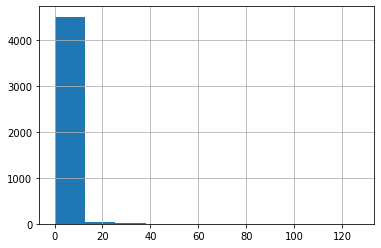

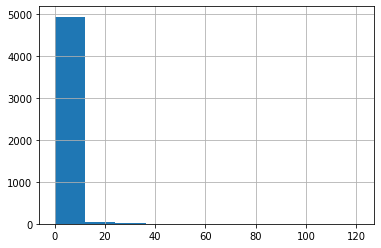

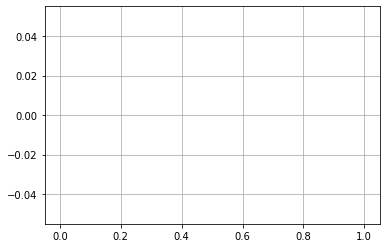

id                               d     
HOUSEHOLD_2_436_CA_3_evaluation  d_1945   NaN
HOUSEHOLD_2_303_CA_2_evaluation  d_1964   NaN
FOODS_2_032_WI_1_evaluation      d_1954   NaN
HOUSEHOLD_2_138_WI_3_evaluation  d_1948   NaN
HOUSEHOLD_2_431_TX_1_evaluation  d_1969   NaN
                                           ..
FOODS_3_324_WI_1_evaluation      d_1943   NaN
FOODS_3_678_TX_3_evaluation      d_1962   NaN
HOBBIES_1_314_CA_2_evaluation    d_1967   NaN
HOBBIES_1_127_CA_3_evaluation    d_1944   NaN
HOBBIES_2_104_TX_1_evaluation    d_1956   NaN
Name: sold_lag_28, Length: 5000, dtype: float16

In [15]:
col = "sold_lag_28"
data["train"][0].sample(n=5000)[col].hist()
plt.show()
data["validation"][0].sample(n=5000)[col].hist()
plt.show()
data["evaluation"][0].sample(n=5000)[col].hist()
plt.show()
data["evaluation"][0].sample(n=5000)[col]

In [5]:
model_path = os.path.join("models","XGBoost_"+feature_maker.name+".mdl")

if True:#os.path.exists(model_path):
    print("loading trained model...")
    model = xgb.XGBRegressor()
    model.load_model(model_path)
    
else:
    print("start training XGBoost")
    model = xgb.XGBRegressor(objective="reg:squarederror",
                             tree_method="gpu_hist",
                             random_state=0,
                             verbose=2,
                             n_estimators=1000,
                             )

    model.fit(X=data["train"][0], y=data["train"][1], 
              #sample_weight=None, 
              #base_margin=None, 
              eval_set=[data["train"],data["validation"]], 
              #eval_metric=None, 
              early_stopping_rounds=100, 
              verbose=True, 
              #xgb_model=None, 
              #sample_weight_eval_set=None
              )
    model.save_model(model_path)
print("  -- completed\n")

loading trained model...
  -- completed



#### [prediction]

In [70]:
# prediction
print("start prediction")
pred_mask = data["evaluation"][1].isna()
data["evaluation"][1].loc[pred_mask] = model.predict(data["evaluation"][0])
print("  -- completed\n")

start prediction
  -- completed



#### [submission]

In [71]:
# submission 
print("start submission")
sub_path = os.path.join("submission_point","XGBoost_"+feature_maker.name+"_submission.csv")


sub_cols = ["id"] + [f"F{i}" for i in range(1, 29)]

valid = data["validation"][1]
evalu = data["evaluation"][1]

del data
gc.collect()

valid = pd.DataFrame(valid.values,
                     index=valid.index,
                     columns=[feature_maker.target_col])
evalu = pd.DataFrame(evalu.values,
                     index=evalu.index,
                     columns=[feature_maker.target_col])

valid = valid.reset_index()
evalu = evalu.reset_index()

valid = pd.pivot(valid,
                 index="id", 
                 columns="d",
                 values=feature_maker.target_col)
evalu = pd.pivot(evalu,
                 index="id", 
                 columns="d", 
                 values=feature_maker.target_col)

valid = valid.reset_index()
evalu = evalu.reset_index()

valid.columns = sub_cols
evalu.columns = sub_cols

valid["id"] = valid["id"].str.replace("_evaluation","_validation")

pd.concat([valid,evalu]).to_csv(sub_path,index=False)
print("  -- completed")

start submission
  -- completed
